In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import trustworthiness
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import silhouette_score, accuracy_score
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import pdist
from scipy.stats import spearmanr
import umap
from umap import UMAP

In [2]:
class EncoderPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, preprocessor, reducer):
        self.preprocessor = preprocessor
        self.reducer = reducer
    def fit(self, X, y=None):
        X_transformed = self.preprocessor.fit_transform(X)
        self.reducer.fit(X_transformed)
        return self
    def transform(self, X):
        X_transformed = self.preprocessor.transform(X)
        return self.reducer.transform(X_transformed)
    def fit_transform(self, X, y=None):
        X_transformed = self.preprocessor.fit_transform(X)
        return self.reducer.fit_transform(X_transformed)
class DecoderPipeline:
    def __init__(self, model):
        self.model = model
    def fit(self, X, y):
        self.model.fit(X, y)
        return self
    def predict(self, X):
        return self.model.predict(X)
    def predict_proba(self, X):
        return self.model.predict_proba(X)

##**Business Understanding**

This dataset includes data on many credit card clients including demographic, financial, and payment history information for each client. The objective of dimensionality reduction is to compress the high dimensional data to make it easier to understand patterns of customer behavior that are difficult to detect with the high dimensional data. PCA and UMAP will be used to for dimensionality reduction of the data to identify patterns. Dimensionality reduction allows businesses to input one feature, customer ID, rather than all features, and use just ID to predict the next month.

##**Data Acquisition**

This dataset, Default of Credit Card Clients Dataset, comes from Kaggle as a CSV file.

##**Data Cleaning & Preprocessing**

In [4]:
url="https://raw.githubusercontent.com/FederatedAI/FATE/master/examples/data/UCI_Credit_Card.csv"
df = pd.read_csv(url)

df = df.drop(columns = ["ID"]) # drop identifier column
target_col = "default.payment.next.month"
labels = df[target_col]

X = df.drop(columns=[target_col])

categorical_cols = ["SEX", "EDUCATION", "MARRIAGE", "PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"]
# define categorical features
numerical_cols = [col for col in X.columns if col not in categorical_cols]
# define numerical features

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
])

df_transformed = preprocessor.fit_transform(df)
if hasattr(df_transformed, "toarray"):
    df_transformed = df_transformed.toarray()

print(df.head())

   LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0    20000.0    2          2         1   24      2      2     -1     -1   
1   120000.0    2          2         2   26     -1      2      0      0   
2    90000.0    2          2         2   34      0      0      0      0   
3    50000.0    2          2         1   37      0      0      0      0   
4    50000.0    1          2         1   57     -1      0     -1      0   

   PAY_5  ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0     -2  ...        0.0        0.0        0.0       0.0     689.0       0.0   
1      0  ...     3272.0     3455.0     3261.0       0.0    1000.0    1000.0   
2      0  ...    14331.0    14948.0    15549.0    1518.0    1500.0    1000.0   
3      0  ...    28314.0    28959.0    29547.0    2000.0    2019.0    1200.0   
4      0  ...    20940.0    19146.0    19131.0    2000.0   36681.0   10000.0   

   PAY_AMT4  PAY_AMT5  PAY_AMT6  default.payment.next.month  
0     

##**Exploratory Data Analysis & Statistical Analysis**

In [5]:
print(df)

       LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0        20000.0    2          2         1   24      2      2     -1     -1   
1       120000.0    2          2         2   26     -1      2      0      0   
2        90000.0    2          2         2   34      0      0      0      0   
3        50000.0    2          2         1   37      0      0      0      0   
4        50000.0    1          2         1   57     -1      0     -1      0   
...          ...  ...        ...       ...  ...    ...    ...    ...    ...   
29995   220000.0    1          3         1   39      0      0      0      0   
29996   150000.0    1          3         2   43     -1     -1     -1     -1   
29997    30000.0    1          2         2   37      4      3      2     -1   
29998    80000.0    1          3         1   41      1     -1      0      0   
29999    50000.0    1          2         1   46      0      0      0      0   

       PAY_5  ...  BILL_AMT4  BILL_AMT5  BILL_AMT6 

In [6]:
print(df_transformed)

[[-1.13672015 -1.24601985 -0.64250107 ...  0.          0.
   0.        ]
 [-0.3659805  -1.02904717 -0.65921875 ...  0.          0.
   0.        ]
 [-0.59720239 -0.16115646 -0.29855966 ...  0.          0.
   0.        ]
 ...
 [-1.05964618  0.16430256 -0.64722711 ...  0.          0.
   0.        ]
 [-0.67427636  0.59824792 -0.71798186 ...  0.          0.
   0.        ]
 [-0.90549825  1.14067961 -0.04473888 ...  0.          0.
   0.        ]]


In [7]:
print(df.columns)

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default.payment.next.month'],
      dtype='object')


##**PCA Transformation**

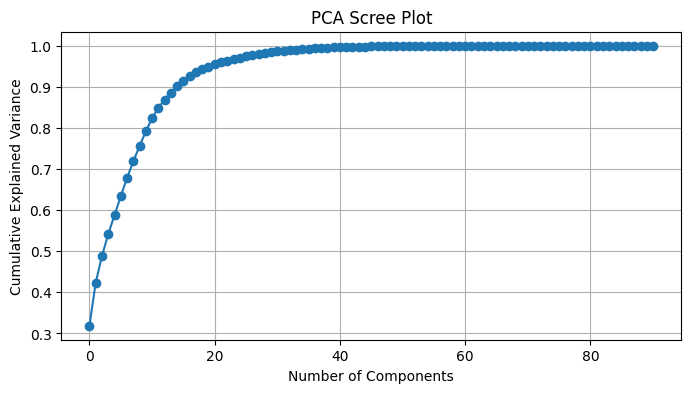

In [8]:
pca_full = PCA().fit(df_transformed)
# compute full PCA before reducing dataset to 2 dimensions

# Scree plot for full PCA
plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_), marker="o")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Scree Plot")
plt.grid(True)
plt.savefig("scree_plot.png")
plt.show()

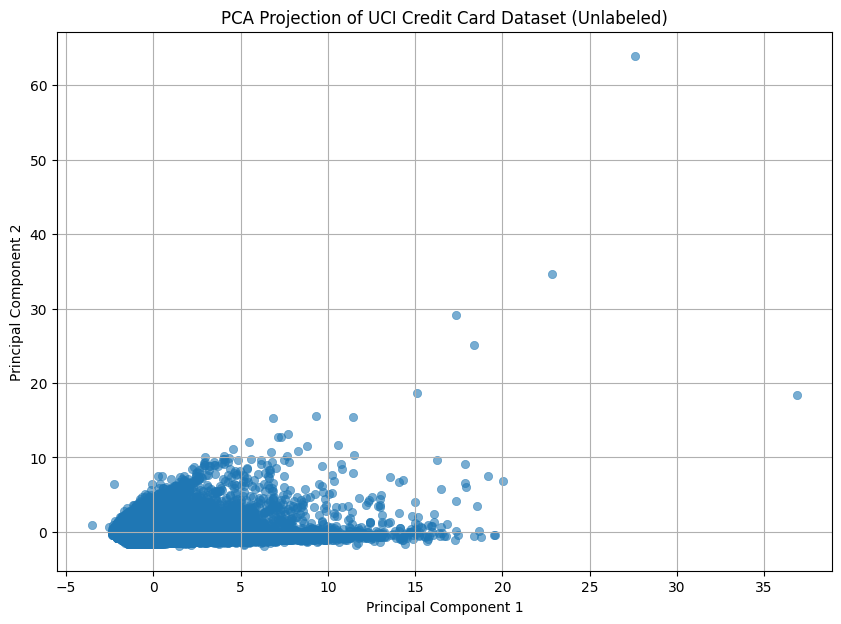

In [9]:
pca = PCA(n_components=2) # reduce dataset to 2 dimensions
df_pca = pca.fit_transform(df_transformed)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=df_pca[:, 0], y=df_pca[:, 1], alpha=0.6, edgecolor=None)
plt.title("PCA Projection of UCI Credit Card Dataset (Unlabeled)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.savefig("pca_plot.png")
plt.show()

# explained variance
explained_variance_pca = np.sum(pca.explained_variance_ratio_)

# PCA reconstruction
df_pca_inv = pca.inverse_transform(df_pca)
reconstruction_error = np.mean((df_transformed - df_pca_inv) ** 2)

df_sample1, df_pca_sample = resample(df_transformed, df_pca, n_samples=5000)
pca_trust = trustworthiness(df_sample1, df_pca_sample, n_neighbors=15)

In [10]:
print("Explained Variance (2D):", explained_variance_pca)
print("PCA Reconstruction Error:", reconstruction_error)

Explained Variance (2D): 0.42379475508810366
PCA Reconstruction Error: 0.12341395461685165


##**UMAP Transformation**

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


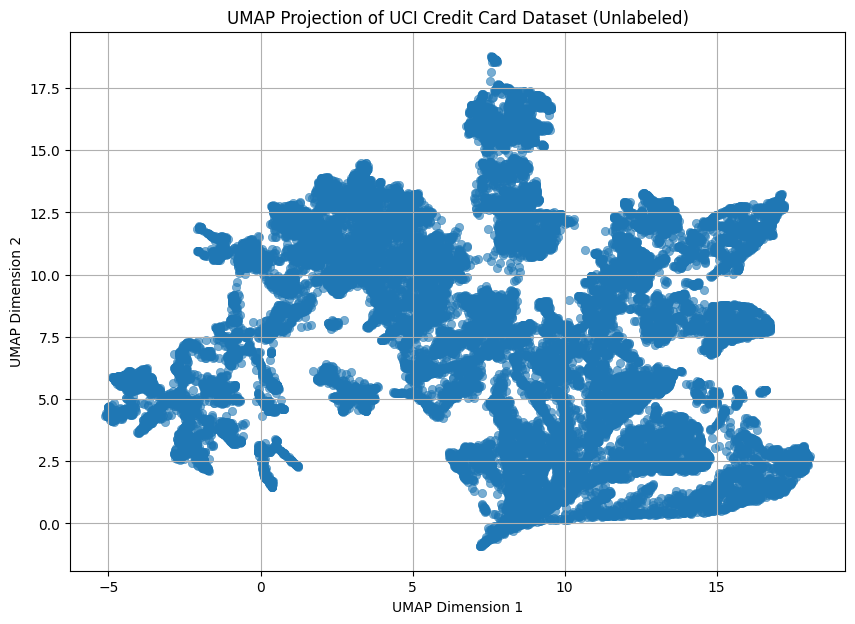

In [11]:
nn = 10
md = 0.2

# set up UMAP
umap_reducer = umap.UMAP(n_components=2, n_neighbors = nn, min_dist = md, random_state=42)
# fit UMAP on preprocessed data
df_umap = umap_reducer.fit_transform(df_transformed)

# plot UMAP projection
plt.figure(figsize=(10, 7))
sns.scatterplot(x=df_umap[:, 0], y=df_umap[:, 1], alpha=0.6, edgecolor=None)
plt.title("UMAP Projection of UCI Credit Card Dataset (Unlabeled)")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.grid(True)
plt.savefig("umap_plot.png")
plt.show()

# measure trustworthiness
df_sample2, df_umap_sample = resample(df_transformed, df_umap, n_samples=5000, random_state=42)
umap_trust = trustworthiness(df_sample2, df_umap_sample, n_neighbors=nn)

# spearman correlation
dist_high = pdist(df_sample2)
dist_low = pdist(df_umap_sample)
corr, _ = spearmanr(dist_high, dist_low)

# combined score
combined = umap_trust + corr

In [15]:
print("UMAP Trustworthiness:", umap_trust)
print("UMAP Spearman Correlation:", corr)
print("UMAP Combined Score:", combined)

UMAP Trustworthiness: 0.9482349603771693
UMAP Spearman Correlation: 0.28313310989394574
UMAP Combined Score: 1.231368070271115


In [16]:
pca_sil = silhouette_score(df_pca, labels)
umap_sil = silhouette_score(df_umap, labels)

print("PCA Silhouette Score (2D):", pca_sil)
print("UMAP Silhouette Score (2D):", umap_sil)

PCA Silhouette Score (2D): -0.03729128899791384
UMAP Silhouette Score (2D): 0.020896511


##**Model Evaluation & Explainability**

In [17]:
# PCA transformation
print("Explained Variance (2D):", explained_variance_pca)
print("PCA Reconstruction Error:", reconstruction_error)

# UMAP transformation
print("\nUMAP Trustworthiness:", umap_trust)
print("UMAP Spearman Correlation:", corr)
print("UMAP Combined Score:", combined)

Explained Variance (2D): 0.42379475508810366
PCA Reconstruction Error: 0.12341395461685165

UMAP Trustworthiness: 0.9482349603771693
UMAP Spearman Correlation: 0.28313310989394574
UMAP Combined Score: 1.231368070271115


##**Monitoring & Maintenance**

In [18]:
# train logistic regression model
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(df_pca, labels, test_size=0.2, random_state=42)
X_train_umap, X_test_umap, y_train_umap, y_test_umap = train_test_split(df_umap, labels, test_size=0.2, random_state=42)

logreg_pca = LogisticRegression().fit(X_train_pca, y_train_pca)
logreg_umap = LogisticRegression().fit(X_train_umap, y_train_umap)

accuracy_pca = accuracy_score(y_test_pca, logreg_pca.predict(X_test_pca))
accuracy_umap = accuracy_score(y_test_umap, logreg_umap.predict(X_test_umap))

In [20]:
pca_encoder = EncoderPipeline(preprocessor=preprocessor, reducer=pca)
umap_encoder = EncoderPipeline(preprocessor=preprocessor, reducer=umap_reducer)

The PCA and UMAP transformations were logged using MLflow to track model performance across experiment runs and make predictions. The end-to-end project was also wrapped in a pipeline structure and saved as a pickle file in MLflow. This part of the project was removed to streamline the workflow and focus on direct model evaluation. Pipeline storage was not essential for the final deployment of the project.